Attempting to re-create plots from before code refactor. These plots are originally from `Model.ipynb` in the original `hyperspectral` repository.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_objects import Fluorophore
from imaging_model import fast_form_A
from information_matrix import read_qe, fast_form_q_vec, FIM

Get fluorophore data: (copied from data_objects.py to help future-proof code)

In [2]:
fluorophore_string_list = ["mEmerald", "mTagBFP2", "mCherry", "mNeptune2.5"]
brightness_list         = [39.1,       32.38,      15.85,     22.8         ]
wavelength_range = (400,900)

fluorophore_list = []
for fluorophore_name, fluorophore_brightness in zip(fluorophore_string_list, brightness_list):
    fluorophore_list.append(Fluorophore(fluorophore_name, fluorophore_brightness, index_range=wavelength_range))

list(map(Fluorophore.get_name, fluorophore_list))

['mEmerald', 'mTagBFP2', 'mCherry', 'mNeptune2.5']

Specify other parameters:

In [3]:
illumination_wavelengths = np.array([405, 488, 561, 637])
k = np.array([1,1,1,1]) # we will first compute A without k, and then use A to find new k values
bin_width = 10

params_wo_k = (illumination_wavelengths, k, wavelength_range, bin_width, fluorophore_list)

Imaging model before $k$ is specified:

In [4]:
fast_form_A(*params_wo_k)[10,0]

0.017846902914808855

Now, we want to balance out our emission strengths so that a similar amount of information (photons) is collected from each fluorophore. (copied from original code)

In [5]:
def calc_k_strength(i, desired_photons):
        A_constant_k = fast_form_A(*params_wo_k)
        illumination_one = A_constant_k[0:50, 0:4]
        illumination_two = A_constant_k[50:100, 0:4]
        illumination_three = A_constant_k[100:150, 0:4]
        illumination_four = A_constant_k[150:200, 0:4]
        if 0 <= i < 50: 
                sliced_average = np.average(illumination_one)
                k = 1/(sliced_average) * desired_photons
        elif 50 <= i < 100:
                sliced_average = np.average(illumination_two)
                k = 1/(sliced_average) *desired_photons
        elif 100 <= i < 150:
                sliced_average = np.average(illumination_three)
                k = 1/(sliced_average) * desired_photons
        elif 150 <= i < 200:
                sliced_average = np.average(illumination_four)
                k = 1/(sliced_average) * desired_photons
        return k

In [6]:
calc_k_strength(10, 100)

30740.88858655248

Imaging model with k specified: (copied from original code)

In [7]:
def form_k_list(desired_photons):
    k_list = []
    for i in [0, 50, 100, 150]:
        k = calc_k_strength(i, desired_photons)
        k_list.append(k)
        
    return k_list

def form_matrix_A(desired_photons):
    k_list = form_k_list(desired_photons)
    return fast_form_A(illumination_wavelengths, np.array(k_list), wavelength_range, bin_width, fluorophore_list)

Created a list of matrices so we are now able to create multiple "A" matrices for desired photon values. (copied from original code)

In [8]:
def calc_A_for_varying_photons(desired_photons_list):
    # Input: list of average detected photons desired
    # Output: list of corresponding A matrices
    matrix_A_list = []
    for desired_photons in desired_photons_list:
        A = form_matrix_A(desired_photons)
        matrix_A_list.append(A)

    return matrix_A_list

Create a vector consisting of some concentration of each fluorophore (copied from original code)

In [9]:
x = [1, 1, 1, 1]

Function to calculate FOM from $A$ and $x$.

In [10]:
qe = read_qe(wavelength_range)
q_vec = fast_form_q_vec(qe, wavelength_range, bin_width, len(illumination_wavelengths))

def calc_FOM(A, x):
    F = FIM(A, x, q_vec, 2)
    FIM_inv = np.linalg.inv(F)
    CRLB = np.diagonal(FIM_inv)
    FOM_list = np.array(x) / np.sqrt(CRLB)
    
    return FOM_list

Function to determine average photons detected using a for-loop (copied from original code)

In [11]:
def calc_avg_detected_photons(A):
    avg_photons_detected_list = []
    for illum_count in range(4):
        # start = 50 * illum_count
        # end = 50 * (illum_count + 1)
        # print(f"Start row: {start}, End row: {end}")
        A_section = A[50 * illum_count : 50 * (illum_count + 1), :]
        avg_photons_detected = np.average(A_section)
        avg_photons_detected_list.append(avg_photons_detected)

    return avg_photons_detected_list

In [12]:
def calc_multiple_photons_detected(desired_photons_list):
    # Output: a list of the photons detected on average for each of the fluorophores 
    #       (i.e fist list corresponds to the avg photons detected for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) 
    photons_detected_list = []
    for matrix in A_for_desired_photons:
        photons_detected_varying = calc_avg_detected_photons(matrix)
        photons_detected_list.append(photons_detected_varying)
    # return photons_detected_list
    multiple_photons_detected_list = []
    for j in range(4):
        photon_spectra = [item[j] for item in photons_detected_list]
        multiple_photons_detected_list.append(photon_spectra)
    
    return multiple_photons_detected_list 
        

multiple_photons_detected_list = calc_multiple_photons_detected([100, 200, 300]) 
print(multiple_photons_detected_list)

[[99.99999999999999, 199.99999999999997, 299.99999999999994], [100.0, 200.0, 300.00000000000006], [100.00000000000001, 200.00000000000003, 300.0], [100.00000000000001, 200.00000000000003, 300.0]]


In [13]:
A = form_matrix_A(200)
calc_avg_detected_photons(A)

[199.99999999999997, 200.0, 200.00000000000003, 200.00000000000003]

Plotting the FOMs against avg # of detected photons for desired_photons = 100, 200, 300 using $\vec{x} = [1,1,1,1]$.

Function to input desired_photon_list and have a list of multiple FOMs for each fluorophore returned

Function will solve for matrix A for each of the desired photon values, then solve for the FOMs for each of the matrices, then return a list of multiple values of FOMs for each fluorophore. Turns the lists of FOMs for each fluorophore into a function that returns a list of lists, with each list containing the FOMs for a specific fluorophore and the inputted desired photon values (copied from original code)

In [14]:
def calc_multiple_FOMs(desired_photons_list, x):
    # Input: two lists 
    # Output: returns a list of the FOMs for each of the fluorophoress 
    #       (i.e fist list corresponds to the FOMs for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) # this produces a list of matrices, each 200x4
    # x = [1, 1, 1, 1] # concentration of each fluorophore
    FOM_list_varying_photons = []
    for matrix in A_for_desired_photons: # for each matrix in A_for_desired_photons
        calculated_FOMs = calc_FOM(matrix, x) # do this. it will loop on its own (that's what the for-loop is for)
        FOM_list_varying_photons.append(calculated_FOMs) # append the FOM list you get for each matrix into the empty list you created
    FOM_spectra_list = []
    for j in range(4):
        FOM_spectra = [item[j] for item in FOM_list_varying_photons]
        FOM_spectra_list.append(FOM_spectra)
    
    return FOM_spectra_list

In [15]:
def calc_avg_detected_photons_per_fluor(A):
    # Input: 200x4 numpy array
    # Output: list of average photons detected
    avg_photons_detected_list = []
    for j in range(4):
        A_section = A[:, j]
        avg_photons_detected = np.average(A_section)
        avg_photons_detected_list.append(avg_photons_detected)

    return avg_photons_detected_list

calc_avg_detected_photons_per_fluor(A)

[225.15167228636608, 168.84383722782076, 102.30197673088698, 303.7025137549262]

In [16]:
def calc_photons_detected_per_fluor(desired_photons_list):
    # Input: list of desired photons 
    # Output: a list of the photons detected on average for each of the fluorophores 
    #       (i.e fist list corresponds to the avg photons detected for each desired photon value for mEmerald)
    A_for_desired_photons = calc_A_for_varying_photons(desired_photons_list) 
    photons_detected_list = []
    for matrix in A_for_desired_photons:
        photons_detected = calc_avg_detected_photons_per_fluor(matrix)
        photons_detected_list.append(photons_detected)
    multiple_photons_detected_list = []
    for j in range(4):
        photon_spectra = [item[j] for item in photons_detected_list]
        multiple_photons_detected_list.append(photon_spectra)
    
    return multiple_photons_detected_list 

Generating a large set of data to later plot subsets of the data

In [17]:
desired_photons_list = [*range(1000, 100000, 1000)]
FOM_spectra_list = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list = calc_photons_detected_per_fluor(desired_photons_list)

In [18]:
print(len(desired_photons_list))

99


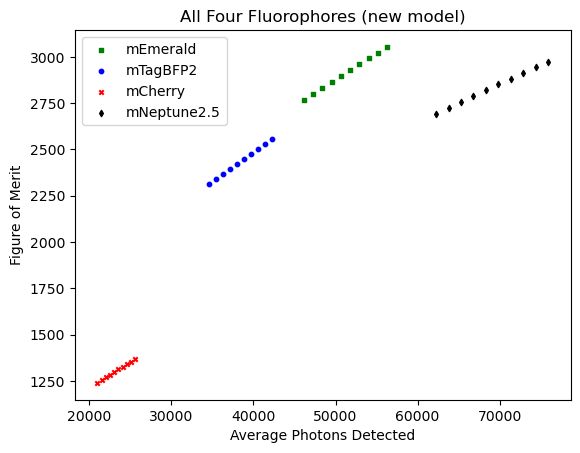

In [19]:
start_idx = 40
end_idx = 50
FOM_spectra_list_subset = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset[j] = FOM_spectra_list[j][start_idx : end_idx]
    avg_photons_detected_list_subset[j] = avg_photons_detected_list[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset[0], FOM_spectra_list_subset[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset[1], FOM_spectra_list_subset[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset[2], FOM_spectra_list_subset[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_subset[3], FOM_spectra_list_subset[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('Figure of Merit')
plt.xlabel('Average Photons Detected')
plt.title('All Four Fluorophores (new model)')
#plt.savefig('Figures/Average Photons Detected vs FOMs for Same 10 Index Range All Fluorophores.pdf')
plt.show()

In [20]:
desired_photons_list = [*range(1000, 100000, 1000)]
FOM_spectra_list_no_mNeptune = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 0])
avg_photons_detected_list_no_mNeptune = calc_photons_detected_per_fluor(desired_photons_list)

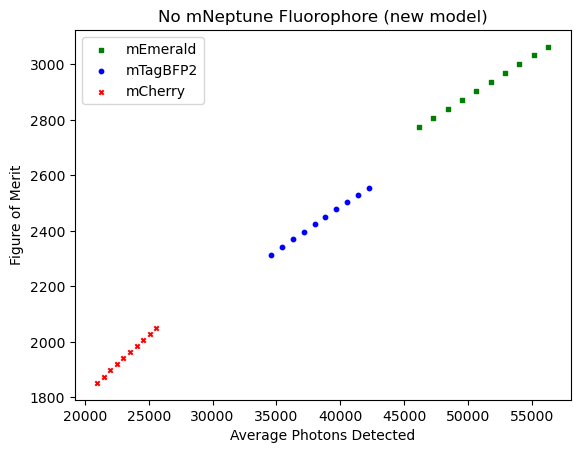

In [21]:
start_idx = 40
end_idx = 50
FOM_spectra_list_subset_no_mNeptune = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset_no_mNeptune = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset_no_mNeptune[j] = FOM_spectra_list_no_mNeptune[j][start_idx : end_idx]
    avg_photons_detected_list_subset_no_mNeptune[j] = avg_photons_detected_list_no_mNeptune[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[0], FOM_spectra_list_subset_no_mNeptune[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[1], FOM_spectra_list_subset_no_mNeptune[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[2], FOM_spectra_list_subset_no_mNeptune[2], s=10, c='r', marker="x", label='mCherry')
# ax1.scatter(avg_photons_detected_list_subset_no_mNeptune[3], FOM_spectra_list_subset_no_mNeptune[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('Figure of Merit')
plt.xlabel('Average Photons Detected')
plt.title('No mNeptune Fluorophore (new model)')
#plt.savefig('Figures/Average Photons Detected vs FOMs for Same 10 Index Range No mNeptune2p5.pdf')
plt.show()

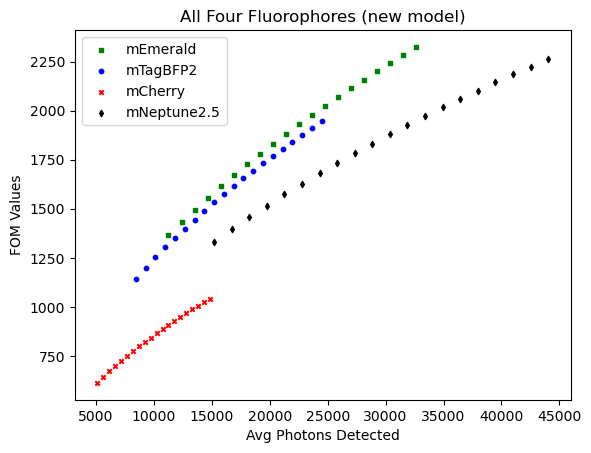

In [22]:
start_idx = 9
end_idx = 29
FOM_spectra_list_subset = np.empty([4, (end_idx - start_idx)])
avg_photons_detected_list_subset = np.empty([4, (end_idx - start_idx)])
for j in range(4):
    FOM_spectra_list_subset[j] = FOM_spectra_list[j][start_idx : end_idx]
    avg_photons_detected_list_subset[j] = avg_photons_detected_list[j][start_idx : end_idx]

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list_subset[0], FOM_spectra_list_subset[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list_subset[1], FOM_spectra_list_subset[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list_subset[2], FOM_spectra_list_subset[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list_subset[3], FOM_spectra_list_subset[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('All Four Fluorophores (new model)')
#plt.savefig('Figures/Avg Photons Detected vs FOMs for All Fluorophores.pdf')
plt.show()

Extending data included so that Average Photons Detected is the same for each fluorophore

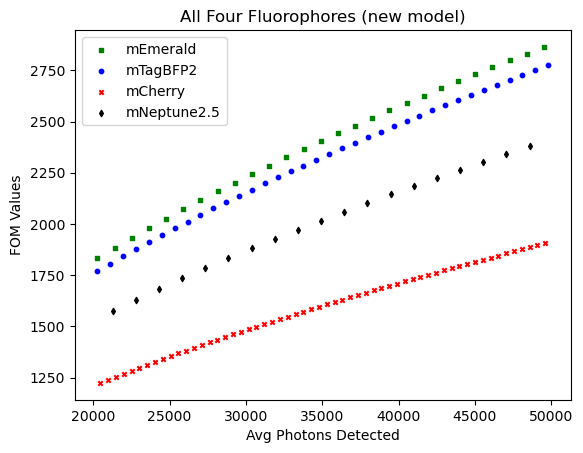

In [23]:
results_list = [] # will be list of dataframes
for j in range(4):
    dict = {'desired photons': desired_photons_list, 'FOM': FOM_spectra_list[j], 'avg detected': avg_photons_detected_list[j]}
    df = pd.DataFrame(dict)
    results_list.append(df)

results_sliced_list = []
for j in range(4):
    df = results_list[j]
    df_sliced = df.loc[(df['avg detected'] >= 20000) & (df['avg detected'] <= 50000)]
    results_sliced_list.append(df_sliced)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(results_sliced_list[0]['avg detected'], results_sliced_list[0]['FOM'], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(results_sliced_list[1]['avg detected'], results_sliced_list[1]['FOM'], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(results_sliced_list[2]['avg detected'], results_sliced_list[2]['FOM'], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(results_sliced_list[3]['avg detected'], results_sliced_list[3]['FOM'], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('All Four Fluorophores (new model)')
#plt.savefig('Figures/Avg Photons Detected vs FOMs for All Fluorophores.pdf')
plt.show()

Plot each fluorophore with points/FOMs for desired photons = [*range(100, 3000, 100)] all on same plot

In [24]:
desired_photons_list = [*range(100, 3000, 100)]
FOM_spectra_list = calc_multiple_FOMs(desired_photons_list, [1, 1, 1, 1])
avg_photons_detected_list = calc_photons_detected_per_fluor(desired_photons_list)

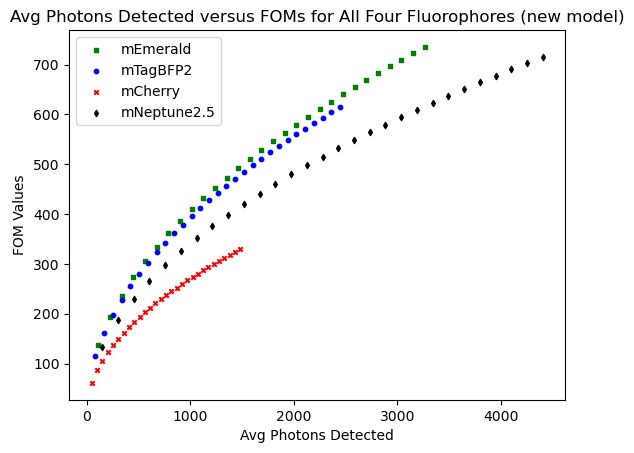

In [25]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(avg_photons_detected_list[0], FOM_spectra_list[0], s=10, c='g', marker="s", label='mEmerald')
ax1.scatter(avg_photons_detected_list[1], FOM_spectra_list[1], s=10, c='b', marker="o", label='mTagBFP2')
ax1.scatter(avg_photons_detected_list[2], FOM_spectra_list[2], s=10, c='r', marker="x", label='mCherry')
ax1.scatter(avg_photons_detected_list[3], FOM_spectra_list[3], s=10, c='black', marker="d", label='mNeptune2.5')
plt.legend(loc='upper left')
plt.ylabel('FOM Values')
plt.xlabel('Avg Photons Detected')
plt.title('Avg Photons Detected versus FOMs for All Four Fluorophores (new model)')
#plt.savefig('Figures/Avg Photons Detected vs FOMs.pdf')
plt.show()

There are more plots, but I will copy them over as needed.